# $Q^3$ Qomputing Fall 2025
## Submission by: Gianluca Pedrani

### Goal: Build a Circuit that checks if a binary string is a palindrome without erasing any of the intermediate steps.

### Understanding the problem: 
From the problem statement, it is see that the although the problem may be simple for small bit strings, the complexity and amount of possible palindromes increases proportionally to $ 2^n $. Below, I will workout by hand the first bit string lengths to start to construct the problem (letting $\Omega$ denote the sample space, and $X$ denote the subspace of palindromes): 

$$
\begin{gather*}
    n = 1:  2 \text{ palindromes} \\ 
    \Omega = \{0 , 1 \}. \quad X = \{0, 1\} \\[10pt]
    n = 2:  2 \text{ palindromes} \\ 
    \Omega = \{00, 01, 10, 11\}  \quad X = \{00, 11\} \\[10pt] 
    n = 3: 4 \text{ palindromes} \\ 
    \Omega = \{000, 001, 010, 100, 011, 110, 101, 111\}, \quad X = \{000, 010, 101, 111\}
\end{gather*}
$$

As we can see, there is an interesting pattern immerging: namely that if one bit string is confirmed to be palindrome then its complement (defined as negating each bit in the bit string, ie: $ \; x_1 x_2 \cdots x_n \mapsto \neg x_1 \neg x_2 \cdots \neg x_n $ ). And as a quick santity check, we can check the first values for n upto 100 just to get a baseline of what we are working with: 

In [124]:
import numpy as np
import pandas as pd

def find_complement(string: str) -> str:
    complement = ""
    for character in string[2:]:
        if character == "0": 
            complement += "1"
        if character == "1": 
            complement += "0"

    return complement

def check_palindromes(n: int) -> (int, list):
    number_of_palindromes = 0 
    biggest_int_from_bitstring_length = 2**n 
    list_of_palindromes = []

    for integer in range(0, int(biggest_int_from_bitstring_length/2)):
        #Splice removes the first 2 characters from binning the integer
        current_bitstring = format(integer, f'#0{n+2}b') 
        complement =  find_complement(current_bitstring)       
        backwards_bitstring = "0b" + current_bitstring[-1:1:-1]
        
        #Check if palindrome: 
        if eval(f"{current_bitstring} ^ {backwards_bitstring}") == 0: 
            number_of_palindromes += 2 
            list_of_palindromes.append(current_bitstring[2:])
            list_of_palindromes.append(complement)
            
        elif current_bitstring != backwards_bitstring: 
            continue 
            
        else: 
            print("How did I get here?!")

    #Sanity Check
    if number_of_palindromes == len(list_of_palindromes):
        return (number_of_palindromes, list_of_palindromes)
    else: 
        raise Error

Solutions = {} 
for i in range(1,15): 
    Solutions[f"{i}"] = check_palindromes(i)

In [147]:
dataframe= pd.DataFrame(Solutions).T
dataframe.rename(columns={0:"Number of palindromes", 1:"palindromes"})


,Number of Palindrones,Palindrones
1,2,"[0, 1]"
2,2,"[00, 11]"
3,4,"[000, 111, 010, 101]"
4,4,"[0000, 1111, 0110, 1001]"
5,8,"[00000, 11111, 00100, 11011, 01010, 10101, 011..."
6,8,"[000000, 111111, 001100, 110011, 010010, 10110..."
7,16,"[0000000, 1111111, 0001000, 1110111, 0010100, ..."
8,16,"[00000000, 11111111, 00011000, 11100111, 00100..."
9,32,"[000000000, 111111111, 000010000, 111101111, 0..."
10,32,"[0000000000, 1111111111, 0000110000, 111100111..."


# Creating a Quantum (Reversible) Circuit
Now that we have a classical solution, we can start to construct a reversible quantum circuit that can both check if a given input is a palindrome while persevering the intermediate steps: 

## Starting Simple - the 2-qubit oracle - 
Working in the computational basis, we already know that the basis states we will be working with are: 
$$
\begin{gather*}
    \text{In the palindrome subspace: } \quad \ketbra{00}{00}, \quad \ketbra{11}{11} \\
    \text{Outside of the palindrome subspace: } \quad \ketbra{01}{01}, \quad \ketbra{10}{10}
\end{gather*}
$$

We want to construct a circuit that can take in the two "good" inputs and return a logical true value, while discarding the other two "bad" states with a logical "false" value. So lets consider the action of the following qubits + ancilla system: 

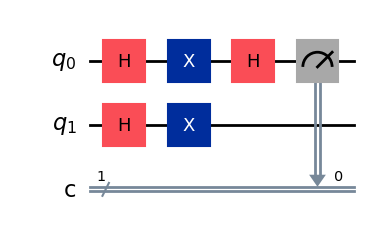

In [191]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2,1) 
circuit.h(0)
circuit.h(1) 
circuit.x(0)
circuit.x(1) 
circuit.h(0)
circuit.measure(0,0)
circuit.draw(output='mpl')

We can view the evolution of the system in steps to confirm our assumptions: 
$$
\begin{gather*}
    \ket{\psi_1} = 
    \begin{cases}
        \ket{00} \\ 
        \ket{01} \\ 
        \ket{10} \\ 
        \ket{11} 
    \end{cases}, \quad \rightarrow &&
    \ket{\psi_2} = 
    \begin{cases}
        \ket{++} \\ 
        \ket{+-} \\ 
        \ket{-+} \\ 
        \ket{--} 
    \end{cases} \quad \rightarrow &&
    \ket{\psi_3} = 
    \begin{cases}
        1  \cdot \ket{++} \\
        -1 \cdot \ket{+-} \\ 
        -1 \cdot \ket{-+} \\ 
        1  \cdot \ket{--} 
    \end{cases} \quad \rightarrow
    \ket{\psi_4} = 
    \begin{cases}
        1  \cdot \ket{0+} \\
        -1 \cdot \ket{0-} \\ 
        -1 \cdot \ket{1+} \\ 
        1 \cdot \ket{1-} 
    \end{cases}
\end{gather*}
$$

Which, if we now measure $\ket{\psi_4}$ in the Z basis for qubit 1, we can now distingush which of the four states was our input state using a combination of Phase and which state the 1st qubit is in (and all in one querry too boot)! Thus, we've done a reversible quantum computation. Well read readers might note that this construction is equivalent to the Deutsch-Jozsa algorithum - beacause it is actually a restriction of that same classification problem (also knoiwn as the Bernstein-Vazirani algorithm). 


## Are there general n-qubit Solution:
Extrapolating from our previous oracle, we need to be careful and consider how best to extend this solution to higher dimensions. For the immediate next case (n=3), following the exact same procedre will not yeild a valid result since codes from the palindrome subspace and the non-palindrome subspace leak into eachother and can't be distinguished by phase. So a new construction is needed to solve this problem more generally.  

One such construction that accurately determines if a code is a palindrome is below, but do note that it is not reversible as constructed since we do not get specfic information on the input qubit state:

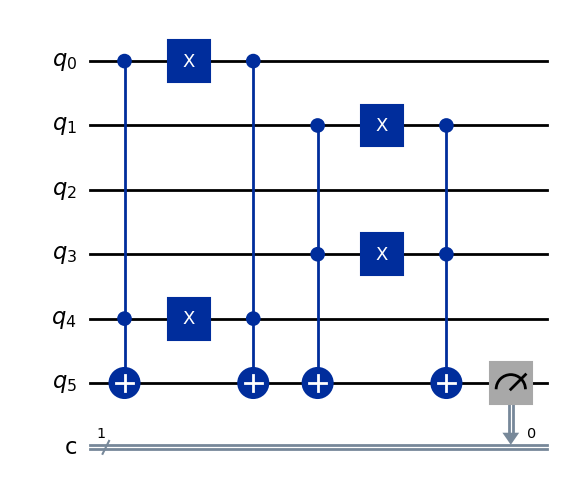

In [200]:
def palindrome_circuit_checker(n: int):
    circ = QuantumCircuit(n+1,1) 
    
    left_index = 0 
    right_index = n-1
    
    while left_index < right_index: 
        circ.ccx(left_index, right_index, n)
        circ.x(left_index)
        circ.x(right_index) 
        circ.ccx(left_index, right_index, n)
        left_index += 1
        right_index -= 1

    circ.measure(n, 0)

    return circ

my_circ = palindrome_circuit_checker(5)
my_circ.draw('mpl')   

We can recover a bit more information if we add conditional phases as such: 

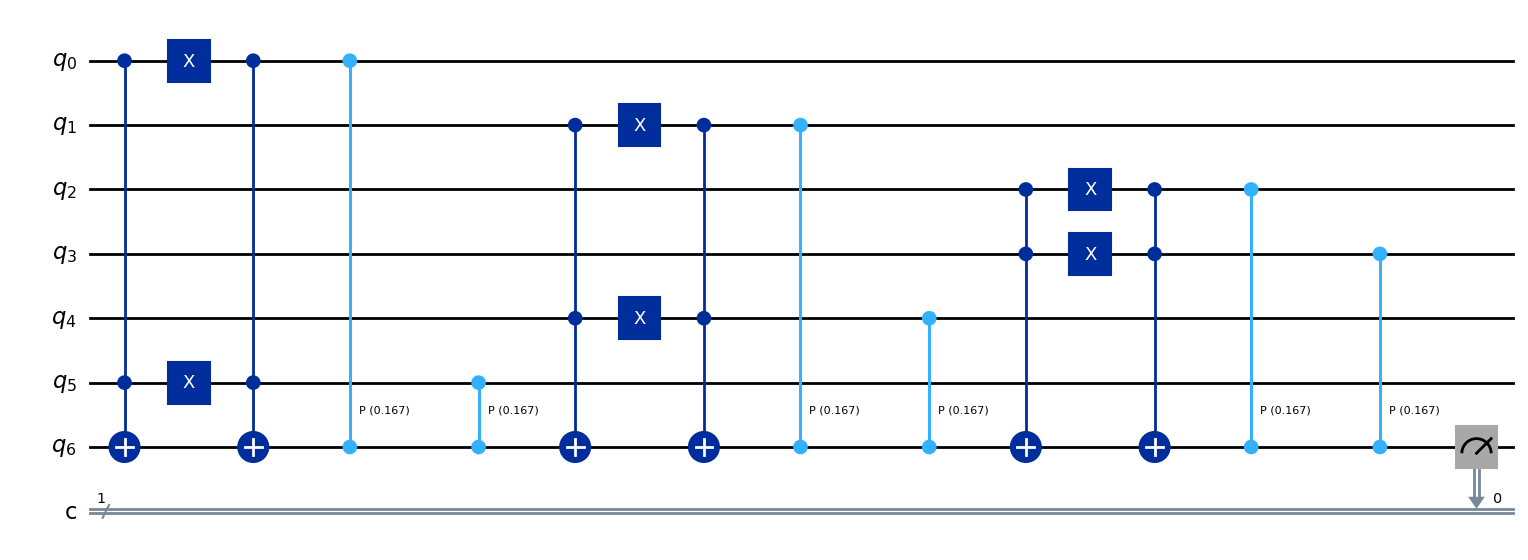

In [206]:
def palindrome_circuit_checker_with_phase(n: int):
    circ = QuantumCircuit(n+1,1) 
    
    left_index = 0 
    right_index = n-1
    if (n % 2) == 0:    
        next
    elif (n % 2) != 0:
        midpoint = int(n/2)
        circ.cp(1/n, midpoint, n)
        
    while left_index < right_index: 
        circ.ccx(left_index, right_index, n)
        circ.x(left_index)
        circ.x(right_index) 
        circ.ccx(left_index, right_index, n)
        circ.cp(1/n, left_index, n)
        circ.cp(1/n, right_index, n)
        left_index += 1
        right_index -= 1

    circ.measure(n, 0)

    return circ

my_circ = palindrome_circuit_checker_with_phase(6)
my_circ.draw('mpl')  

Now, we can at least group palindromes of identical parity together in increments of $\theta = \frac{2\pi}{n}$. For this specific problem, solutions more general than this will either trade off being able to recover the original state of the system (thus making the computation irreversible), or will allow us to cover the original state (and hence be reversible) but not allow us to accuratly tell if the input is a palindrome. 

## Social Implications of Reversible Quantum Computing:
In principle, being able to solve compute problems reversibly can lead to lower energy consumption - as quantum information theory equates information and energy as two forms of the same physical quantity. Moreover, for very large bitstrings, the quantum advantage of well formed algorithms gives a maximum of $\sqrt(n)$ speed up over classical solutions; meaning that more scientists can get results faster and more accuratly as quantum computing becomes more developed and accessable.
